### 7.2 XGBoosting

In [18]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [19]:
# Load data
df = pd.read_csv("stockdata_adj.csv")

# Choose Guizhou Moutai (600519) as the target stock
df = df[df['ts_code'] == '600519.SH']
df = df.sort_values('trade_date')
df['trade_date'] = pd.to_datetime(df['trade_date'])
df.index = range(len(df))
df

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,adj_factor,adj_open,adj_high,adj_low,adj_close,adj_volume
0,600519.SH,2014-09-22,160.71,160.71,156.84,156.94,160.85,-3.91,-2.4300,37191.54,586709.101,6.125,984.34875,984.34875,960.6450,961.25750,6072.088163
1,600519.SH,2014-09-23,156.70,157.50,156.36,157.48,156.94,0.54,0.3400,34546.11,541705.820,6.125,959.78750,964.68750,957.7050,964.56500,5640.181224
2,600519.SH,2014-09-24,156.49,160.50,155.60,160.19,157.48,2.71,1.7200,43448.96,687426.587,6.125,958.50125,983.06250,953.0500,981.16375,7093.707755
3,600519.SH,2014-09-25,160.92,163.98,160.90,162.19,160.19,2.00,1.2500,56851.44,924878.313,6.125,985.63500,1004.37750,985.5125,993.41375,9281.867755
4,600519.SH,2014-09-26,161.50,163.12,159.20,162.31,162.19,0.12,0.0700,22716.65,366907.285,6.125,989.18750,999.11000,975.1000,994.14875,3708.840816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2427,600519.SH,2024-09-12,1380.00,1385.00,1334.91,1335.06,1380.00,-44.94,-3.2565,47948.31,6482445.000,8.020,11067.60000,11107.70000,10705.9782,10707.18120,5978.592269
2428,600519.SH,2024-09-13,1331.00,1332.00,1297.30,1304.13,1335.06,-30.93,-2.3167,56005.11,7329376.917,8.020,10674.62000,10682.64000,10404.3460,10459.12260,6983.180798
2429,600519.SH,2024-09-18,1300.00,1300.01,1266.66,1266.90,1304.13,-37.23,-2.8548,46185.31,5895948.011,8.020,10426.00000,10426.08020,10158.6132,10160.53800,5758.766833
2430,600519.SH,2024-09-19,1262.00,1292.88,1245.83,1261.00,1266.90,-5.90,-0.4657,59988.21,7623739.997,8.020,10121.24000,10368.89760,9991.5566,10113.22000,7479.826683


In [20]:
# import statsmodels
# from matplotlib import rcParams

# df_close = df[['trade_date', 'adj_close']].copy()
# df_close = df_close.set_index('trade_date')
# df_close.head()

# # Since A shares are traded on weekdays, the trading days are about 244 days a year
# decomposition = statsmodels.tsa.seasonal.seasonal_decompose(df_close['adj_close'], model='additive', period=244)

# fig = decomposition.plot()
# fig.set_size_inches(20, 8)


In [21]:
# Get factors which we calculated in the previous section
df_factors = pd.read_csv("stockdata_factors.csv")

df_factors

,trade_date,adj_open,adj_high,adj_low,adj_close,adj_volume,HIGHLOW_PCT,PCT_Change,PCT_Change_overnight,MA5,...,psar_down_ind,psar_up,psar_up_ind,sma,stc,trix,vortex_ind_diff,vortex_ind_neg,vortex_ind_pos,wma
0,2014-09-22,984.34875,984.34875,960.6450,961.25750,6072.088163,2.402192,-2.345840,NaN,NaN,...,0.0,953.0500,0.0,961.257500,0.000000,-87.921760,0.000000,0.000000,0.000000,0.000000
1,2014-09-23,959.78750,964.68750,957.7050,964.56500,5640.181224,0.012700,0.497766,0.003441,NaN,...,0.0,953.0500,0.0,962.911250,0.000000,0.000672,-0.003187,0.003757,0.000570,0.000000
2,2014-09-24,958.50125,983.06250,953.0500,981.16375,7093.707755,0.193520,2.364368,0.017209,NaN,...,1.0,953.0500,0.0,968.995417,0.000000,0.005137,-0.001247,0.005375,0.004128,0.000000
3,2014-09-25,985.63500,1004.37750,985.5125,993.41375,9281.867755,1.103644,0.789212,0.012485,NaN,...,0.0,953.0500,1.0,975.100000,0.000000,0.014428,0.005597,0.005700,0.011298,0.000000
4,2014-09-26,989.18750,999.11000,975.1000,994.14875,3708.840816,0.499045,0.501548,0.000740,978.90975,...,0.0,953.0500,0.0,978.909750,0.000000,0.026673,0.003392,0.009765,0.013156,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2427,2024-09-12,11067.60000,11107.70000,10705.9782,10707.18120,5978.592269,3.740656,-3.256522,-0.032565,11013.16024,...,0.0,11228.0802,0.0,11251.851480,5.903866,-0.115318,-0.263263,1.075545,0.812282,11045.511138
2428,2024-09-13,10674.62000,10682.64000,10404.3460,10459.12260,6983.180798,2.137057,-2.018783,-0.023167,10862.59276,...,0.0,11228.0802,0.0,11200.896410,2.951933,-0.133750,-0.456916,1.197712,0.740796,10913.845907
2429,2024-09-18,10426.00000,10426.08020,10158.6132,10160.53800,5758.766833,2.613466,-2.546154,-0.028548,10689.20036,...,0.0,11228.0802,0.0,11137.321870,1.475966,-0.161491,-0.546055,1.225719,0.679664,10738.658809
2430,2024-09-19,10121.24000,10368.89760,9991.5566,10113.22000,7479.826683,2.528152,-0.079239,-0.004657,10501.53236,...,0.0,11228.0802,0.0,11072.472150,0.737983,-0.194870,-0.514633,1.217831,0.703198,10579.511711


In [22]:
fig = make_subplots(rows=4, cols=1)
fig.add_trace(go.Scatter(x=df_factors['trade_date'], y=df_factors['adj_close'], name='Close Price'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_factors['trade_date'], y=df_factors['MA5'], name='MA5'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_factors['trade_date'], y=df_factors['macd'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df_factors['trade_date'], y=df_factors['rsi'], name='RSI'), row=3, col=1)
fig.add_trace(go.Scatter(x=df_factors['trade_date'], y=df_factors['vwap'], name='VWAP'), row=4, col=1)
fig.update_layout(title_text='Technical Indicators')
fig.show()


In [23]:
# Shift label column 'adj_close' by 1 to predict the next day's price
df_factors.loc[:, 'label'] = df_factors.loc[:, "adj_close"].pct_change().shift(-1)
print(df_factors.shape)

df_factors = df_factors.iloc[30:]
df_factors = df_factors[:-1]

df_factors.index = range(len(df_factors))
df_factors

(2432, 75)


,trade_date,adj_open,adj_high,adj_low,adj_close,adj_volume,HIGHLOW_PCT,PCT_Change,PCT_Change_overnight,MA5,...,psar_up,psar_up_ind,sma,stc,trix,vortex_ind_diff,vortex_ind_neg,vortex_ind_pos,wma,label
0,2014-11-10,918.7500,941.90250,912.62500,941.84125,10175.544490,0.006503,2.513333,0.038706,914.46250,...,957.981505,0.0,952.143500,0.812919,-0.115705,-0.356688,1.129103,0.772415,924.691250,-0.002731
1,2014-11-11,945.0875,950.60000,931.06125,939.26875,7788.880000,1.206391,-0.615684,-0.002731,916.86350,...,957.981505,0.0,951.665750,0.996617,-0.129273,-0.265161,1.094411,0.829251,925.735222,-0.003000
2,2014-11-12,937.0025,940.73875,919.97500,936.45125,5032.448980,0.457846,-0.058831,-0.003000,925.12000,...,957.981505,0.0,950.309062,0.696324,-0.138600,-0.366551,1.148664,0.782114,926.889444,-0.008568
3,2014-11-13,935.4100,935.47125,916.79000,928.42750,8025.397551,0.758675,-0.746464,-0.008568,930.54675,...,957.981505,0.0,948.551187,0.348162,-0.146047,-0.376078,1.152292,0.776214,926.783278,0.037670
4,2014-11-14,928.3050,965.48375,924.32375,963.40125,12281.645714,0.216161,3.780681,0.037670,941.87800,...,891.187500,1.0,948.217375,50.174081,-0.144540,-0.147090,1.021903,0.874812,934.366028,0.017547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2396,2024-09-11,11032.3120,11114.75760,10947.30000,11067.60000,2617.926434,0.426087,0.319860,0.001451,11125.15152,...,11228.080200,0.0,11288.675310,11.807732,-0.104627,-0.172296,1.070114,0.897817,11146.835818,-0.032565
2397,2024-09-12,11067.6000,11107.70000,10705.97820,10707.18120,5978.592269,3.740656,-3.256522,-0.032565,11013.16024,...,11228.080200,0.0,11251.851480,5.903866,-0.115318,-0.263263,1.075545,0.812282,11045.511138,-0.023167
2398,2024-09-13,10674.6200,10682.64000,10404.34600,10459.12260,6983.180798,2.137057,-2.018783,-0.023167,10862.59276,...,11228.080200,0.0,11200.896410,2.951933,-0.133750,-0.456916,1.197712,0.740796,10913.845907,-0.028548
2399,2024-09-18,10426.0000,10426.08020,10158.61320,10160.53800,5758.766833,2.613466,-2.546154,-0.028548,10689.20036,...,11228.080200,0.0,11137.321870,1.475966,-0.161491,-0.546055,1.225719,0.679664,10738.658809,-0.004657


In [24]:
# Covariance matrix of factors, plot heatmap

corr = df_factors.corr()

<Axes: >

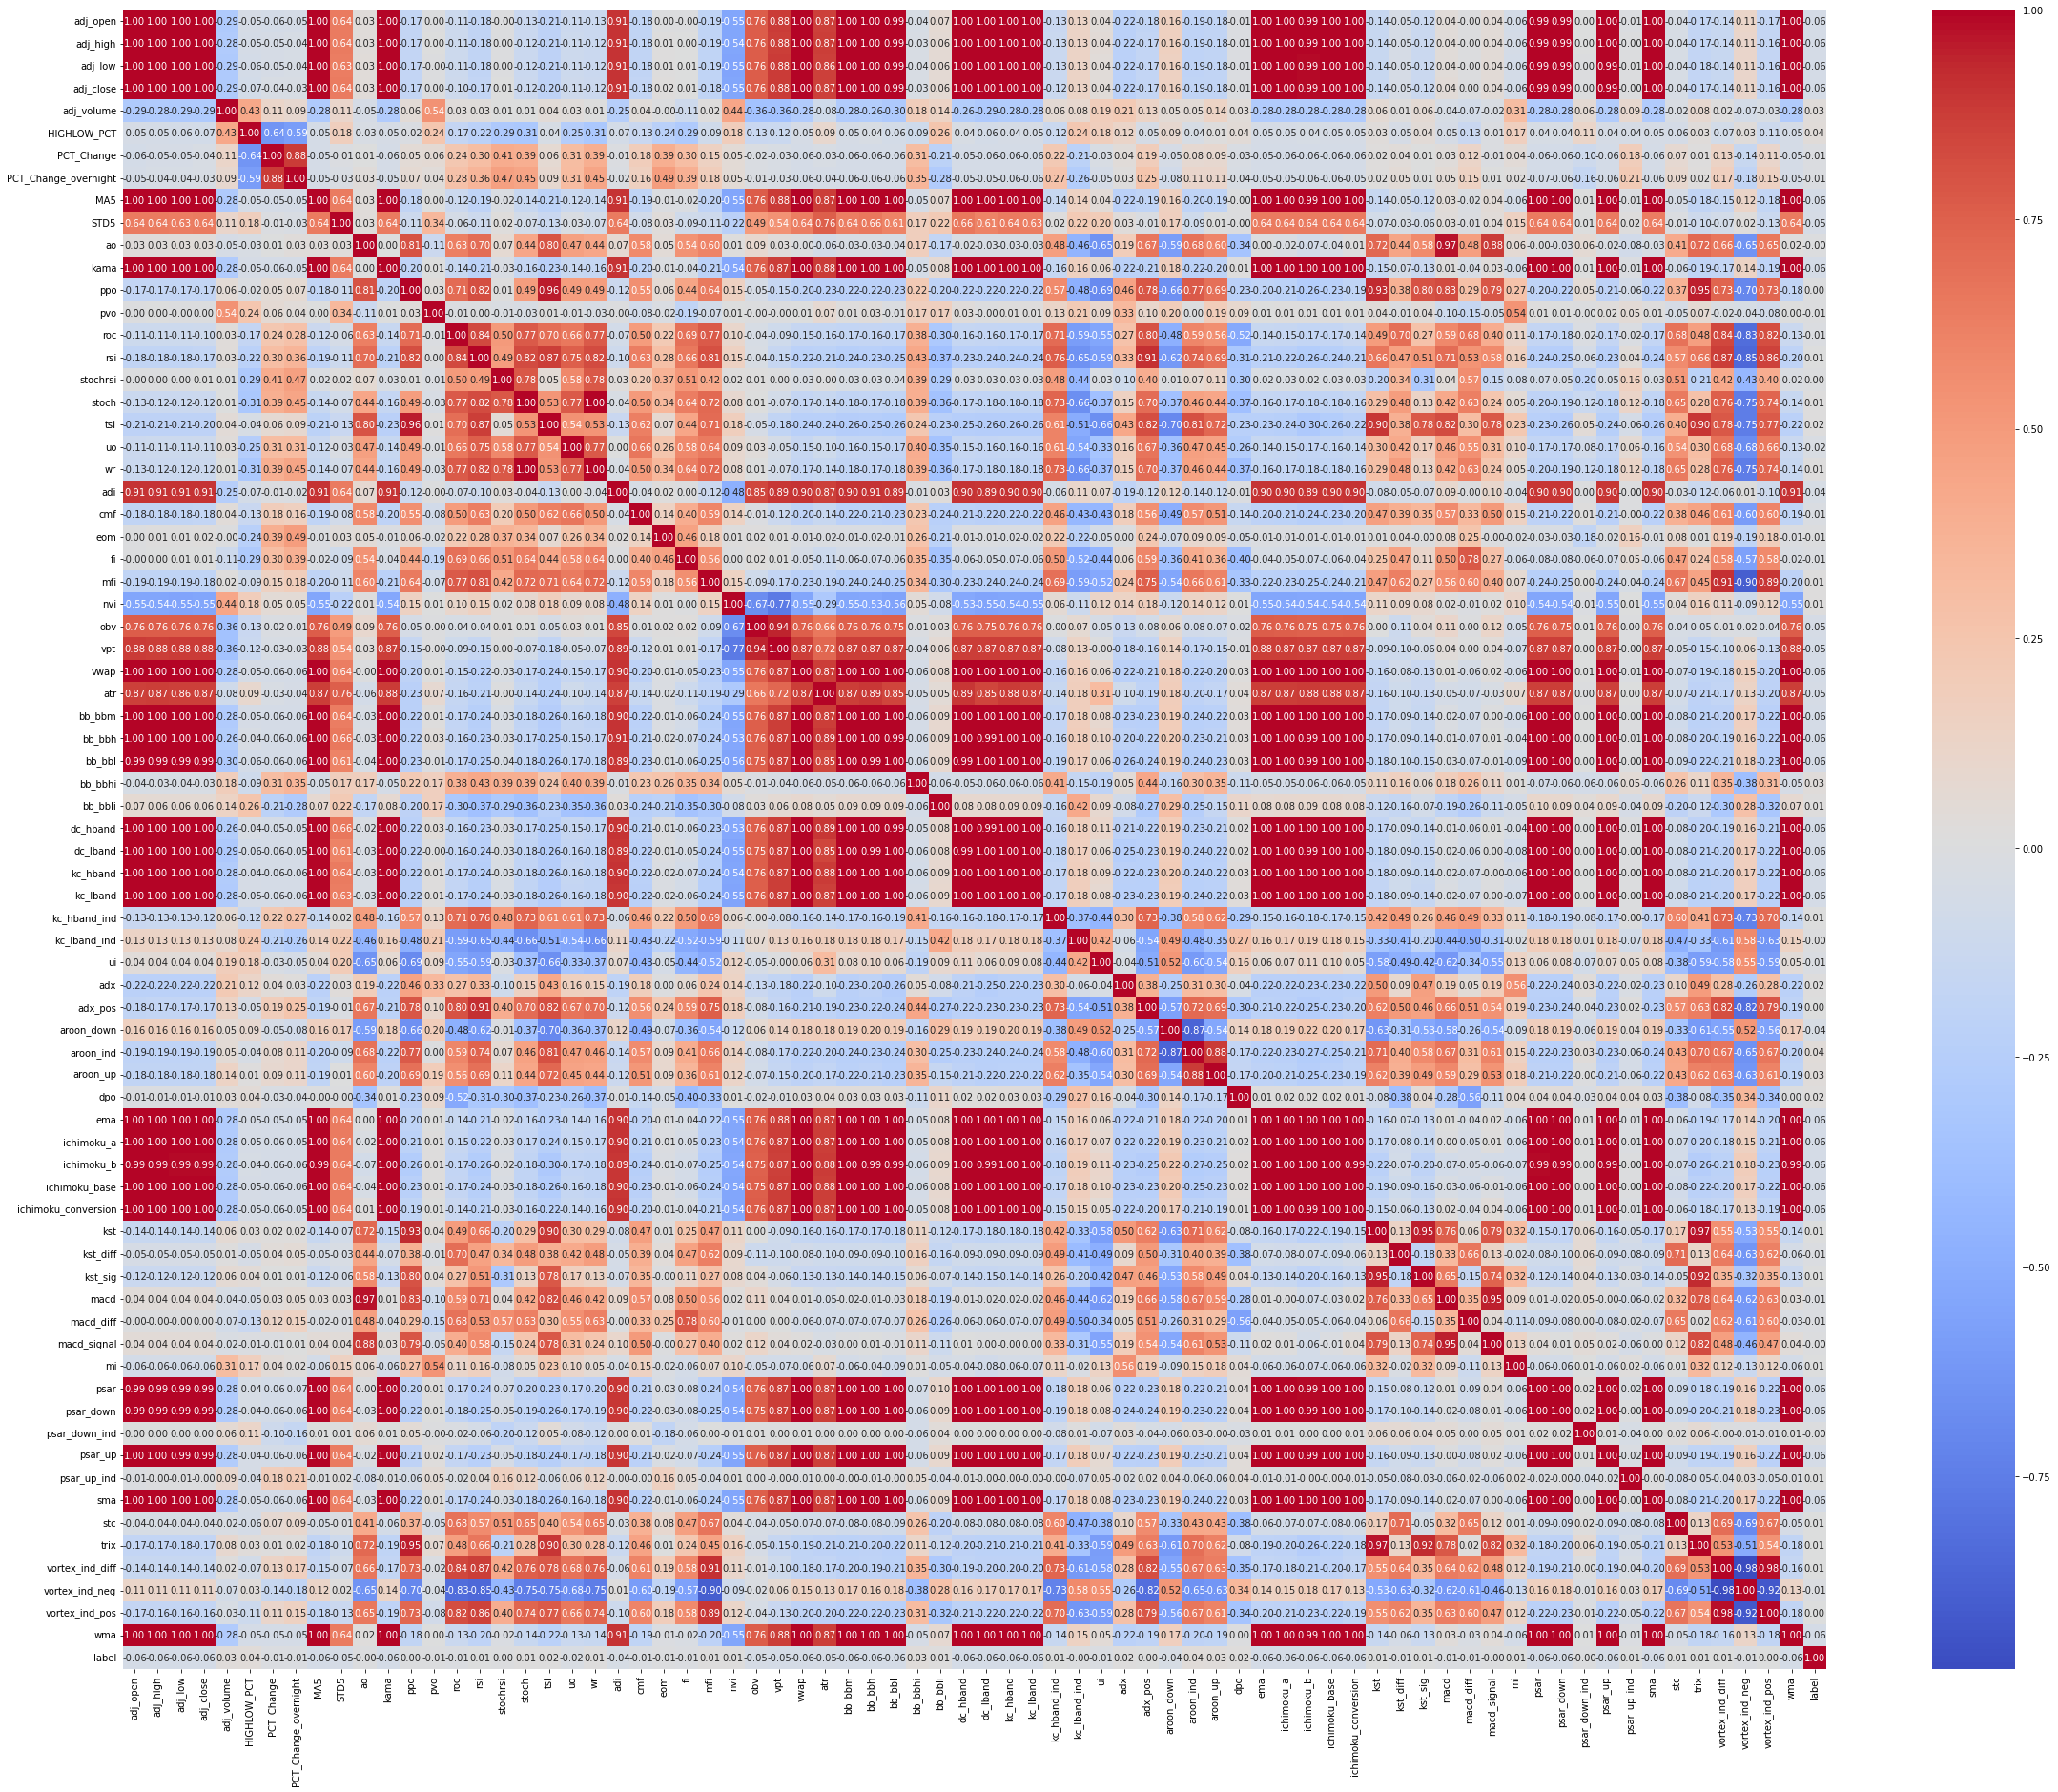

In [25]:
import seaborn as sns
plt.figure(figsize=(40, 32))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')
# plt.savefig("CorMtx_whole.png")

In [26]:
from sklearn import preprocessing

df_factors.dropna(inplace=True)
X = np.array(df_factors.drop(columns=['label']))
X = np.array(df_factors.drop(columns=['trade_date']))
X = preprocessing.scale(X)
y=np.array(df_factors['label'])

train_test_split_idx = int(len(X) * 0.8)

train_df  = df_factors.loc[:train_test_split_idx].copy()
test_df   = df_factors.loc[train_test_split_idx:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.trade_date, y=train_df.adj_close, name='Train'))
fig.add_trace(go.Scatter(x=test_df.trade_date, y=test_df.adj_close, name='Test'))
fig.show()


In [27]:
X_train = X[:train_test_split_idx]
X_test = X[train_test_split_idx:]
y_train = y[:train_test_split_idx]
y_test = y[train_test_split_idx:]

In [28]:
parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

# model = xgb.XGBRegressor(eval_set=(X_train, y_train), objective='reg:squarederror', verbose=False)
model = xgb.XGBRegressor(objective='reg:squarederror')
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.001, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
Best validation score = 0.9909861602002223


* now:

Best params: {'gamma': 0.001, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}

Best validation score = 0.9909861602002223

In [31]:
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.001, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [33]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')
print(f'mean_absolute_error = {mean_absolute_error(y_test, y_pred)}')

y_true = [-0.00140733 -0.00417475 -0.04619493 -0.00336506 -0.0112304 ]
y_pred = [-0.00139364 -0.00394367 -0.04358768 -0.00294237 -0.01079905]
mean_absolute_error = 0.0005367367176814349


C:\Users\25195\AppData\Local\Temp\ipykernel_4464\2700688341.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\25195\AppData\Local\Temp\ipykernel_4464\2700688341.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: >

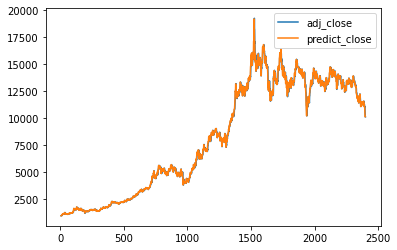

In [35]:
df_factors.loc[:, "predict"] = np.nan
df_factors.loc[:, "predict"][:train_test_split_idx] = clf.predict(X_train)
df_factors.loc[:, "predict"][train_test_split_idx:] = clf.predict(X_test)
df_factors.loc[:, "predict_close"] = df_factors["adj_close"] * (1 + df_factors["predict"])
df_factors.loc[:, "predict_close"] = df_factors["predict_close"].shift(-1)

df_factors[["adj_close", "predict_close"]].plot()